# Import required libraries

In [231]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as xgb 
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

THRESHOLD = 0.001
TEST_SPLIT = 0.15
VAL_SPLIT = 0.15

## Exploratory Data Analysis  

In [232]:
df = pd.read_csv('../datasets/netflix_stock_history.csv', parse_dates=["Date"]).sort_values('Date').set_index('Date') # Load dataset with date parsing - Converts 'Date' column to datetime instead of string

df.columns = df.columns.str.lower().str.replace(' ', '_')
# Display basic dataset information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4870 entries, 2002-05-23 to 2021-09-24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          4870 non-null   float64
 1   high          4870 non-null   float64
 2   low           4870 non-null   float64
 3   close         4870 non-null   float64
 4   volume        4870 non-null   int64  
 5   dividends     4870 non-null   int64  
 6   stock_splits  4870 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 304.4 KB


In [233]:
# Display the first few rows
print("First 5 Rows:")
print(df.head())

First 5 Rows:
                open      high       low     close     volume  dividends  \
Date                                                                       
2002-05-23  1.156429  1.242857  1.145714  1.196429  104790000          0   
2002-05-24  1.214286  1.225000  1.197143  1.210000   11104800          0   
2002-05-28  1.213571  1.232143  1.157143  1.157143    6609400          0   
2002-05-29  1.164286  1.164286  1.085714  1.103571    6757800          0   
2002-05-30  1.107857  1.107857  1.071429  1.071429   10154200          0   

            stock_splits  
Date                      
2002-05-23           0.0  
2002-05-24           0.0  
2002-05-28           0.0  
2002-05-29           0.0  
2002-05-30           0.0  


In [234]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
# Summary statistics of stock prices
print("Statistic Values:")
df.describe()

Missing Values:
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64
Statistic Values:


,open,high,low,close,volume,dividends,stock_splits
count,4870.000000,4870.000000,4870.000000,4870.000000,4.870000e+03,4870.0,4870.000000
mean,104.243285,105.833669,102.608072,104.282593,1.682662e+07,0.0,0.001848
std,155.319234,157.589034,152.978074,155.365529,1.938116e+07,0.0,0.104316
min,0.377857,0.410714,0.346429,0.372857,2.856000e+05,0.0,0.000000
25%,3.898214,3.975000,3.833214,3.902500,6.309850e+06,0.0,0.000000
50%,21.144286,21.406429,20.743572,21.004285,1.085175e+07,0.0,0.000000
75%,124.975002,126.427502,122.847502,124.797503,2.018555e+07,0.0,0.000000
max,606.469971,615.599976,596.549988,606.710022,3.234140e+08,0.0,7.000000


In [235]:
df['dividends'].unique()

array([0])

In [236]:
# Drop 'Dividends' since all are 0s
df = df.drop(columns= ['dividends'], axis=1)


## OHLCV

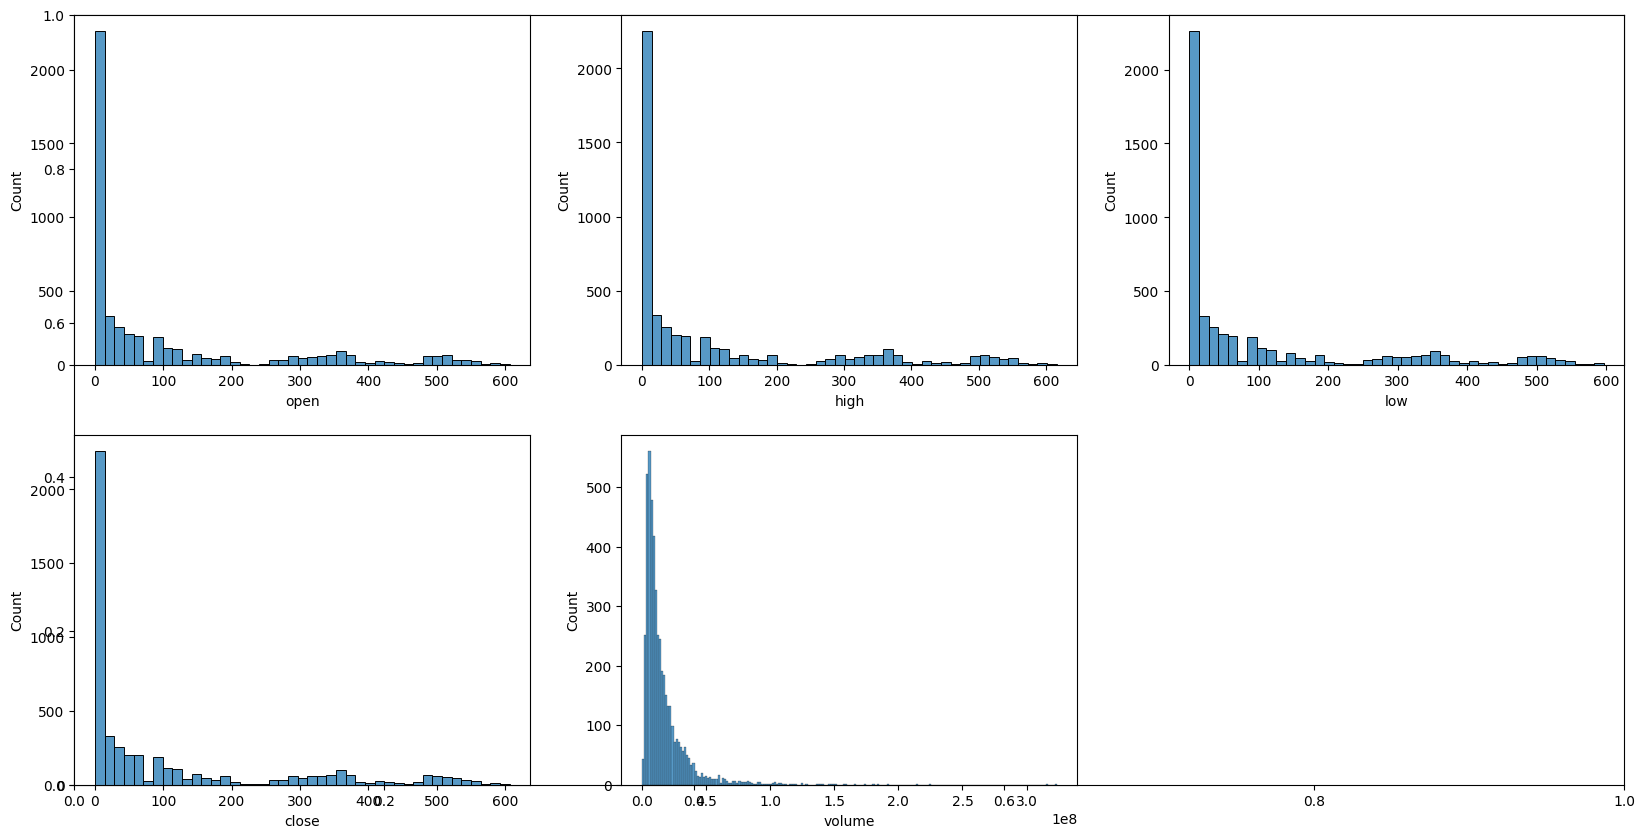

In [237]:
features = ['open', 'high', 'low', 'close', 'volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2, 3 , i+1)
  sns.histplot(df[col])
plt.show()

## Stock Price Trends Over Time

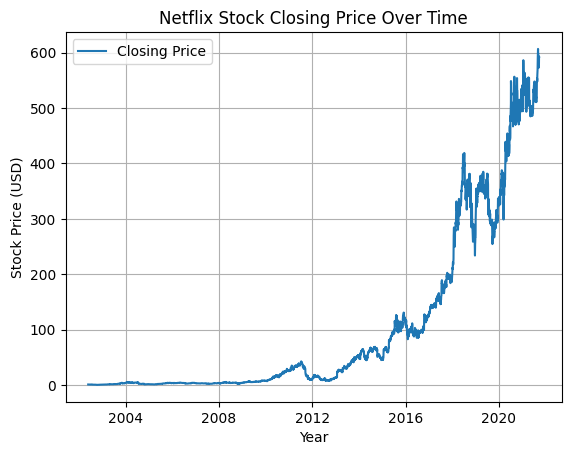

In [238]:
plt.plot(df.index,df["close"], label="Closing Price")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Netflix Stock Closing Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Trading Volume Trends

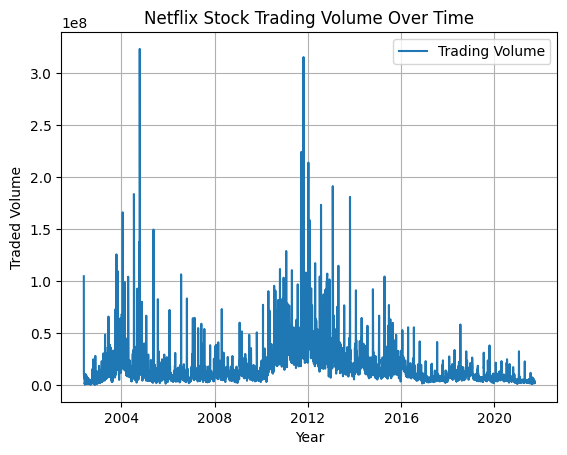

In [239]:
plt.plot(df.index, df["volume"], label="Trading Volume")
plt.xlabel("Year")
plt.ylabel("Traded Volume")
plt.title("Netflix Stock Trading Volume Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Stock Price with Splits

In [240]:
df_splits = df[df["stock_splits"] > 0]

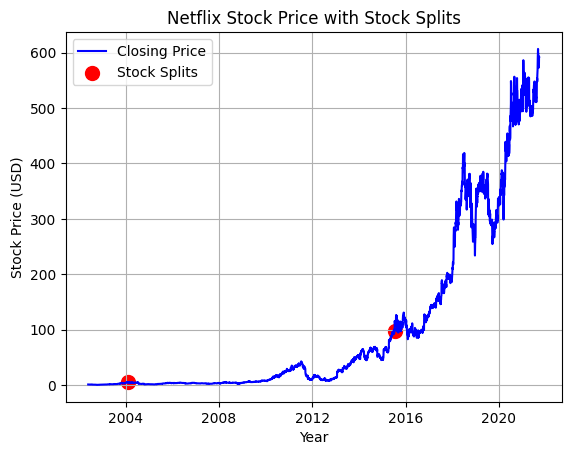

In [241]:
plt.plot(df.index, df["close"], label="Closing Price", color="blue")
plt.scatter(df_splits.index, df_splits["close"], color="red", label="Stock Splits", marker="o",s=100)
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Netflix Stock Price with Stock Splits")
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

In [242]:
# --- Basic returns ---
df["return_1d"] = df.ta.percent_return(length=1)         
df["log_return"] = np.log(df["close"]).diff()

# --- Lagged returns and close prices ---
for lag in range(1, 6):
    df[f"return_lag_{lag}"] = df["return_1d"].shift(lag)
    df[f"close_lag_{lag}"] = df["close"].shift(lag)

# --- Rolling mean / std using pandas_ta SMA & STDEV ---
df["rolling_mean_5"] = ta.sma(df["close"], length=5)
df["rolling_mean_10"] = ta.sma(df["close"], length=10)
df["rolling_std_10"] = ta.stdev(df["close"], length=10)

# --- High-Low range ---
df["range"] = df["high"] - df["low"]

# --- Volatility (std of returns) ---
df["volatility_10"] = ta.stdev(df["return_1d"], length=10)

# --- Momentum ---
df["momentum_5"] = ta.mom(df["close"], length=5)

# --- % change over 5 days ---
df["pct_change_5"] = df.ta.percent_return(length=5)



# Drop rows with any NaN in feature columns
df = df.dropna()  

# Target creation (fixed-horizon next-day return)
df['target_1d_return'] = df['close'].pct_change().shift(-1)
# drop final row(s) where target is NaN
df = df.dropna(subset=['target_1d_return'])
# apply thresholding
df['target_label_raw'] = np.select([df['target_1d_return'] > THRESHOLD, df['target_1d_return'] < -THRESHOLD], [1, -1], 0)
print('Counts of raw labels (1=up, -1=down, 0=flat):')
print(df['target_label_raw'].value_counts())

Counts of raw labels (1=up, -1=down, 0=flat):
target_label_raw
 1    2374
-1    2294
 0     191
Name: count, dtype: int64


In [243]:
# Convert to binary by removing flats
df_binary = df[df['target_label_raw'] != 0].copy()
df_binary['target'] = (df_binary['target_label_raw'] == 1).astype(int) # 1 -> UP, 0 -> DOWN
print('Binary class counts (UP=1, DOWN=0):')
print(df_binary['target'].value_counts())

Binary class counts (UP=1, DOWN=0):
target
1    2374
0    2294
Name: count, dtype: int64


In [244]:
df.head(1)

,open,high,low,close,volume,stock_splits,return_1d,log_return,return_lag_1,close_lag_1,...,close_lag_5,rolling_mean_5,rolling_mean_10,rolling_std_10,range,volatility_10,momentum_5,pct_change_5,target_1d_return,target_label_raw
Date,,,,,,,,,,,,,,,,,,,,,
2002-06-07,1.177857,1.177857,1.103571,1.118571,1369200,0.0,-0.053777,-0.055277,0.030511,1.182143,...,1.076429,1.138857,1.131286,0.043985,0.074286,0.035934,0.042142,0.03915,0.033845,1


# Split the dataset

In [245]:
feature_cols = [c for c in df_binary.columns if c.startswith('return_lag_') or c.startswith('close_lag_')]
feature_cols += ['rolling_mean_5', 'rolling_mean_10', 'rolling_std_10', 'range', 'volatility_10', 'momentum_5', 'pct_change_5', 'log_return']
feature_cols = [f for f in feature_cols if f in df_binary.columns] 
print('Using features:', feature_cols)

Using features: ['return_lag_1', 'close_lag_1', 'return_lag_2', 'close_lag_2', 'return_lag_3', 'close_lag_3', 'return_lag_4', 'close_lag_4', 'return_lag_5', 'close_lag_5', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_10', 'range', 'volatility_10', 'momentum_5', 'pct_change_5', 'log_return']


In [246]:
X = df_binary[feature_cols]
y = df_binary['target']

In [247]:
# Time-aware split (sequential)
n = len(X)
train_end = int(n * (1 - (TEST_SPLIT + VAL_SPLIT)))
val_end = int(n * (1 - TEST_SPLIT))
X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]
print('Train/Val/Test sizes:', len(X_train), len(X_val), len(X_test))

Train/Val/Test sizes: 3267 700 701


In [248]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_cols)
dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feature_cols)
dtest  = xgb.DMatrix(X_test,  feature_names=feature_cols)

watchlist = [(dtrain, 'train'), (dval, 'val')]
# params for binary classification
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 3,
    "lambda": 1.0,
    "verbosity": 1,
    "seed": 42,
    "lambda": 1.0,           # NEW: Add L2 regularization
    "alpha": 0.1          # NEW: Add L1 regularization
}
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=watchlist,
    
    verbose_eval=100,
    evals_result=evals_result,
    
)

# print("\nBest iteration:", model.best_iteration)


[0]	train-auc:0.53495	val-auc:0.48889
[100]	train-auc:0.76073	val-auc:0.47152
[200]	train-auc:0.81008	val-auc:0.46513
[300]	train-auc:0.84736	val-auc:0.46430
[400]	train-auc:0.88128	val-auc:0.46443
[500]	train-auc:0.90233	val-auc:0.46953
[600]	train-auc:0.91970	val-auc:0.46215
[700]	train-auc:0.93435	val-auc:0.46364
[800]	train-auc:0.94560	val-auc:0.46807
[900]	train-auc:0.95561	val-auc:0.46610
[1000]	train-auc:0.96322	val-auc:0.46475
[1100]	train-auc:0.96977	val-auc:0.46683
[1200]	train-auc:0.97568	val-auc:0.46904
[1300]	train-auc:0.98020	val-auc:0.46659
[1400]	train-auc:0.98385	val-auc:0.46599
[1500]	train-auc:0.98700	val-auc:0.46722
[1600]	train-auc:0.98972	val-auc:0.46347
[1700]	train-auc:0.99182	val-auc:0.46485
[1800]	train-auc:0.99348	val-auc:0.46360
[1900]	train-auc:0.99462	val-auc:0.46602
[2000]	train-auc:0.99579	val-auc:0.46498
[2100]	train-auc:0.99650	val-auc:0.46500
[2200]	train-auc:0.99708	val-auc:0.46467
[2300]	train-auc:0.99780	val-auc:0.46613
[2400]	train-auc:0.99838	val

In [249]:
y_prob = model.predict(dval)
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

print("\nTEST METRICS")
print("Accuracy:", acc)
print("F1 Score:", f1)
print("ROC AUC:", auc)
print("\nConfusion Matrix:\n", cm)



TEST METRICS
Accuracy: 0.47
F1 Score: 0.3614457831325301
ROC AUC: 0.46677390906715444

Confusion Matrix:
 [[224 120]
 [251 105]]


AttributeError: `best_iteration` is only defined when early stopping is used.

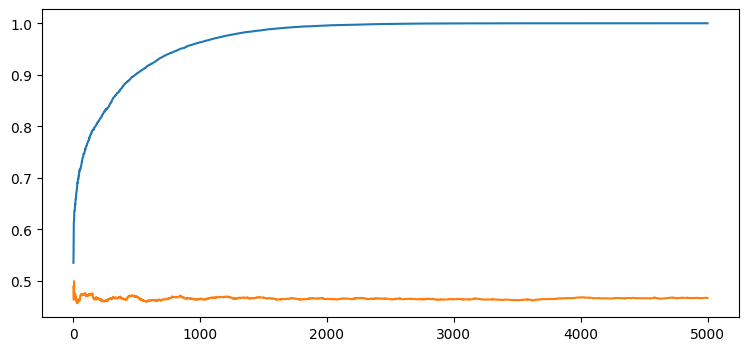

In [250]:
train_auc = evals_result['train']['auc']
val_auc = evals_result['val']['auc']
iters = range(1, len(train_auc) + 1)
plt.figure(figsize=(9,4))
plt.plot(iters, train_auc, label='train AUC')
plt.plot(iters, val_auc, label='val AUC')
plt.axvline(model.best_iteration, color='gray', linestyle='--', label='best_iteration')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])
dfull = xgb.DMatrix(X_full, label=y_full, feature_names=feature_cols)


In [ ]:
watchlist = [(dfull, 'train'), (dtest, 'test')]
model_full = xgb.train(
    params=params,
    dtrain=dfull,
    num_boost_round=2000,
    verbose_eval=50   
)


In [ ]:
y_prob_test = model_full.predict(dtest)
y_pred_test = (y_prob_test > 0.5).astype(int)

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_prob_test)
cm_test = confusion_matrix(y_test, y_pred_test)


In [ ]:
print("Test Accuracy:", acc_test)
print("Test F1:", f1_test)
print("Test ROC AUC:", auc_test)
print("Confusion Matrix:\n", cm_test)


Test Accuracy: 0.4950071326676177
Test F1: 0.36101083032490977
Test ROC AUC: 0.5231281306596617
Confusion Matrix:
 [[247  87]
 [267 100]]


More 